In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import sparse
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

import os
import tensorflow as tf
sns.set()

### And from this spot we start!

### Here we go! @fabriziorom (Who knows - he gets)

In [2]:
train_data = sparse.load_npz("train.npz")
#test_data = pd.read_csv('sample_submission.csv')

In [3]:
train_data = pd.DataFrame(train_data.toarray()).astype('float16')

In [4]:
train_data.shape

(14590, 77888)

### Let's check on the stddev in different features

In [7]:
stddev_array = np.zeros((train_data.shape[1]))

In [8]:
def sttdev_count(sttdev_array, data):
    for i in range(data.shape[1]):
        sttdev_array[i] = data.iloc[:, i][train_data.iloc[:, i] != 0].std()
    return sttdev_array

stddev_array = sttdev_count(stddev_array, train_data)

#too long, but probably gold

In [9]:
stddev_array, len(stddev_array)

(array([0.07385254, 0.0496521 , 0.0243988 , ..., 0.04296875, 0.04498291,
        0.08404541]),
 77888)

In [10]:
sttdev_array_series = pd.Series(data=stddev_array)

### And build the histplot

Text(0.5, 0, 'Standard deviation, $\\sigma$')

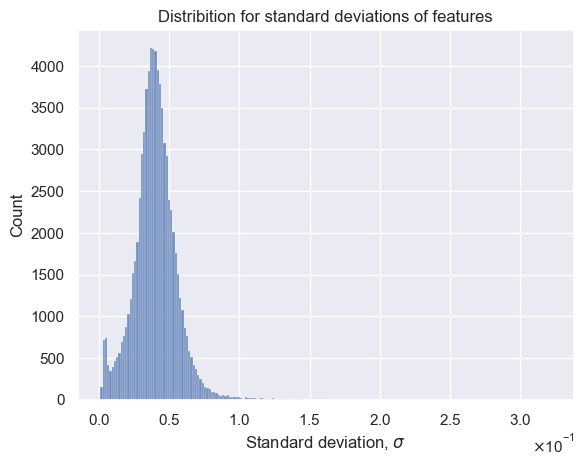

In [11]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = stddev_array, bins = 200)

plt.title('Distribition for standard deviations of features')
plt.xlabel(f'Standard deviation, $\sigma$')

### As we notice, distribution looks like Gaussian. Let's try to calc quantile values

In [12]:
print(sttdev_array_series.quantile(0.125))
print(sttdev_array_series.quantile(0.999))

0.0242919921875
0.12930004882812796


In [13]:
threshold_percent_quantile = sttdev_array_series.quantile(0.125)
nn_percent_quantile = sttdev_array_series.quantile(0.99)

In [14]:
threshold_percent_quantile

0.0242919921875

### We assume low std_dev value to be noise features. Let's denote that the phenomenon of low std_dev corresponds to the all objects having similar feature, smth like narrow gaussian that shows the low variance of data corresponding to this feature. So, I try to make this pre-filtering. 

Otherwise, my office laptop with 4 Gb RAM shall die

In [15]:
def drop_low_stddev_columns(data):
    count = []
    for i in range(data.shape[1]):
        
        if stddev_array[i] <= threshold_percent_quantile:
            count.append(i)
            
    
    return count

count = drop_low_stddev_columns(train_data)

In [16]:
len(count)

9749

In [17]:
train_data = train_data.drop(columns = count).astype('float16')

In [18]:
train_data.shape

(14590, 68139)

In [19]:
import psutil
print(f"Memory: {psutil.Process().memory_info().rss / 1024**2:.2f} Mb")

Memory: 1926.60 Mb


In [ ]:
from scipy import sparse
sparse.save_npz("my_matrix.npy", train_data)

In [21]:
pca_analysis = PCA()
pca_analysis.fit(train_data)

cumulative_variance_ratio = np.cumsum(pca_analysis.explained_variance_ratio_)

In [ ]:
def n_components(ratio):
    n_components = np.argmax(cumulative_variance_ratio >= ratio) + 1
    return n_components

print(n_components(0.9))

### So, the low-level filtering gave us ~9k less features than it was initial, why not?

### Now, we may try the fitting on KMeans or other base algorithms working in initial space. Further we should try some feature decomposition techniques to know how's that visualized.

* First, go with k-means tryna to analyze for clusters number

In [47]:
kmeans_resolution = KMeans(n_clusters=2, random_state = 42, n_init = 'auto').fit(train_data)
print(np.sqrt(kmeans_resolution.inertia_))

In [ ]:
fig, ax = plt.subplots((1, 1))
ax[0].plot(range(2, 10), criterion_array, markers = 's')

ax[0].set_xlabel('$number_clusters$')
ax[0].set_ylabel('$Criterion_value$')